In [1]:
import torch
import torch.optim as optim
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Parse file nums to dicts
annotation_file_path = os.getcwd() + '/../data/annotations'
annotation_ids = []
for file in os.listdir(annotation_file_path):
    filename = os.fsdecode(file)
    file_path = os.path.join(annotation_file_path, filename)

    with open(file_path, 'r') as f:
        for line in f.readlines():
            idx = int(line.replace('\n', ''))
            annotation_ids.append(idx)
            
annotation_ids = list(set(annotation_ids))
train_ids, dev_ids = train_test_split(annotation_ids, test_size=0.2)

In [3]:
#--- hyperparameters ---
N_EPOCHS = 30
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_DEV = 16
LR = 0.001

In [4]:
NUM_CLASSES = 14
DATA_DIR = os.getcwd() + '/../data/'

In [5]:
from collections import defaultdict

class ProjectDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, selected_keys=None, transform=None, target_transform=None):
        data = defaultdict(list)
        self.data = []
        self.classes = []
        
        for file in os.listdir(annotation_folder):
            filename = os.fsdecode(file)
            cls = filename.split('.')[0]
            self.classes.append(cls)
            file_path = os.path.join(annotation_folder, filename)
            
            with open(file_path, 'r') as f:
                for line in f.readlines():
                    idx = int(line.replace('\n', ''))
                    data[idx].append(cls)
        
        for key, val in data.items():
            if not selected_keys or key in selected_keys:
                filename = f'im{key}.jpg'
                labels = torch.Tensor([x in val for x in self.classes])
                self.data.append({'file': filename, 'labels': labels})
        
        self.image_folder = image_folder
        self.transform = transform
        self.target_transform = target_transform
    
    def __getitem__(self, item):
        data = self.data[item]
        labels = data['labels']
        image_path = os.path.join(self.image_folder, data['file'])
        image = torchvision.io.read_image(image_path, torchvision.io.ImageReadMode.RGB)
        image = image.type(torch.FloatTensor)
        image = torch.div(image, 255)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
            
        return image, labels
    
    def __len__(self):
        return len(self.data)

In [6]:
# We transform image files' contents to tensors
# Plus, we can add random transformations to the training data if we like
# Think on what kind of transformations may be meaningful for this data.
# Eg., horizontal-flip is definitely a bad idea for sign language data.
# You can use another transformation here if you find a better one.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      #transforms.RandomPerspective(distortion_scale=0.2),
                                      #transforms.ColorJitter(),
                                      #transforms.ToTensor()
                                     ])
dev_transform = transforms.Compose([])

annotation_path = DATA_DIR + 'annotations'
image_path = DATA_DIR + 'images'
train_set = ProjectDataset(image_path, annotation_path, selected_keys=train_ids, transform=train_transform)
dev_set = ProjectDataset(image_path, annotation_path, selected_keys=dev_ids, transform=dev_transform)
# test_set  = datasets.ImageFolder(DATA_DIR % 'test',  transform=test_transform)


# Create Pytorch data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_set, batch_size=BATCH_SIZE_DEV, shuffle=True)

In [7]:
#--- model ---
class CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(32768, NUM_CLASSES)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.sigm(out)
        return out

using gpu
 Training: Epoch 0 - Batch 63/64: Loss: 1.3016 | Acc: 4.696% (382/8140)
 Dev: Epoch 0 - Batch 127/128: Loss: 0.5253 | Acc: 38.065% (775/2036)
Epoch dev loss: 67.24005886912346
Previous epoch dev loss: 1000000

 Training: Epoch 1 - Batch 63/64: Loss: 0.3288 | Acc: 4.831% (393/8140)
 Dev: Epoch 1 - Batch 127/128: Loss: 0.2900 | Acc: 39.542% (805/2036)
Epoch dev loss: 37.12328426539898
Previous epoch dev loss: 67.24005886912346

 Training: Epoch 2 - Batch 63/64: Loss: 0.2791 | Acc: 4.894% (398/8140)
 Dev: Epoch 2 - Batch 127/128: Loss: 0.2768 | Acc: 39.475% (803/2036)
Epoch dev loss: 35.43103873729706
Previous epoch dev loss: 37.12328426539898

 Training: Epoch 3 - Batch 63/64: Loss: 0.2701 | Acc: 4.914% (400/8140)Training: Epoch 3 - Batch 38/64: Loss: 0.2712 | Acc: 4.859% (242/4992)Training: Epoch 3 - Batch 55/64: Loss: 0.2712 | Acc: 4.867% (348/7168)
 Dev: Epoch 3 - Batch 127/128: Loss: 0.2741 | Acc: 39.729% (808/2036)
Epoch dev loss: 35.086870312690735
Previous epoch dev loss

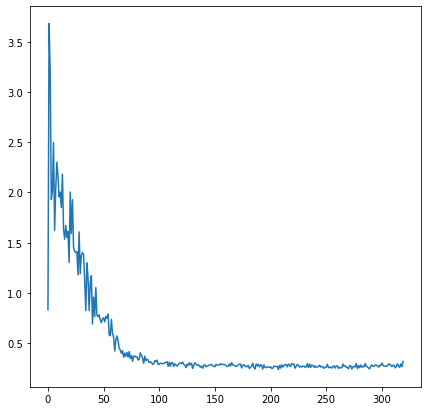

In [12]:
#--- set up ---
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using gpu')
else:
    print('using cpu')
    device = torch.device('cpu')

model = CNN().to(device)

# OPTIMIZERS & REGURALIZATION
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.05)
loss_function = nn.BCELoss()

#--- TRAINING WITH DEV SET ---

previous_train_loss = 1000000
previous_dev_loss = 1000000

batch_losses = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    train_correct = 0
    total = 0
    for batch_num, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Compute prediction error
        optimizer.zero_grad()
        pred = model(data)
        loss = loss_function(pred, target)

        train_loss += loss.item()
        
        batch_losses.append(loss.item())
        
        total += len(target)
        train_correct += torch.sum((pred > 0.5).float() == target) / torch.sum(target)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        print('\r', 'Training: Epoch %d - Batch %d/%d: Loss: %.4f | Acc: %.3f%% (%d/%d)' % 
              (epoch, batch_num, len(train_loader), train_loss / (batch_num + 1), 
               100. * train_correct / total, train_correct, total), end='')
    
    print()
    dev_loss = 0
    dev_total = 0
    dev_correct = 0
    
    for batch_num, (data, target) in enumerate(dev_loader):
        data, target = data.to(device), target.to(device)
                
        # Compute prediction error
        pred = model(data)
        loss = loss_function(pred, target)
        dev_loss += loss.item()
        
        dev_total += len(target)
        dev_correct += torch.sum((pred > 0.5).float() == target) / torch.sum(target)
        
        print('\r', 'Dev: Epoch %d - Batch %d/%d: Loss: %.4f | Acc: %.3f%% (%d/%d)' % 
              (epoch, batch_num, len(dev_loader), dev_loss / (batch_num + 1), 
               100. * dev_correct / dev_total, dev_correct, dev_total), end='')
    
    print()
    print("Epoch dev loss: " + str(dev_loss))
    print("Previous epoch dev loss: " + str(previous_dev_loss))
    print()
    
    # EARLY STOPPING
    if dev_loss > previous_dev_loss:
        print('early stopping')
        break
        
    previous_dev_loss = dev_loss

plt.figure(figsize=(7, 7))
plt.plot(batch_losses)
plt.show()

Evaluating: Batch 0/254: Loss: 1.4169 | Test Acc: 43.750% (7/16)
Evaluating: Batch 1/254: Loss: 1.6263 | Test Acc: 28.125% (9/32)
Evaluating: Batch 2/254: Loss: 1.5920 | Test Acc: 33.333% (16/48)
Evaluating: Batch 3/254: Loss: 1.6690 | Test Acc: 34.375% (22/64)
Evaluating: Batch 4/254: Loss: 1.6779 | Test Acc: 33.750% (27/80)
Evaluating: Batch 5/254: Loss: 1.7182 | Test Acc: 33.333% (32/96)
Evaluating: Batch 6/254: Loss: 1.7236 | Test Acc: 33.929% (38/112)
Evaluating: Batch 7/254: Loss: 1.7260 | Test Acc: 34.375% (44/128)
Evaluating: Batch 8/254: Loss: 1.7612 | Test Acc: 32.639% (47/144)
Evaluating: Batch 9/254: Loss: 1.7763 | Test Acc: 31.875% (51/160)
Evaluating: Batch 10/254: Loss: 1.7641 | Test Acc: 32.386% (57/176)
Evaluating: Batch 11/254: Loss: 1.8100 | Test Acc: 31.250% (60/192)
Evaluating: Batch 12/254: Loss: 1.8064 | Test Acc: 31.250% (65/208)
Evaluating: Batch 13/254: Loss: 1.7928 | Test Acc: 31.250% (70/224)
Evaluating: Batch 14/254: Loss: 1.8259 | Test Acc: 30.000% (72/240

Evaluating: Batch 125/254: Loss: 1.7728 | Test Acc: 33.780% (681/2016)
Evaluating: Batch 126/254: Loss: 1.7732 | Test Acc: 33.760% (686/2032)
Evaluating: Batch 127/254: Loss: 1.7747 | Test Acc: 33.691% (690/2048)
Evaluating: Batch 128/254: Loss: 1.7761 | Test Acc: 33.672% (695/2064)
Evaluating: Batch 129/254: Loss: 1.7768 | Test Acc: 33.654% (700/2080)
Evaluating: Batch 130/254: Loss: 1.7766 | Test Acc: 33.635% (705/2096)
Evaluating: Batch 131/254: Loss: 1.7769 | Test Acc: 33.617% (710/2112)
Evaluating: Batch 132/254: Loss: 1.7762 | Test Acc: 33.647% (716/2128)
Evaluating: Batch 133/254: Loss: 1.7793 | Test Acc: 33.535% (719/2144)
Evaluating: Batch 134/254: Loss: 1.7773 | Test Acc: 33.657% (727/2160)
Evaluating: Batch 135/254: Loss: 1.7763 | Test Acc: 33.594% (731/2176)
Evaluating: Batch 136/254: Loss: 1.7778 | Test Acc: 33.622% (737/2192)
Evaluating: Batch 137/254: Loss: 1.7797 | Test Acc: 33.605% (742/2208)
Evaluating: Batch 138/254: Loss: 1.7785 | Test Acc: 33.633% (748/2224)
Evalua

Evaluating: Batch 243/254: Loss: 1.7872 | Test Acc: 33.555% (1310/3904)
Evaluating: Batch 244/254: Loss: 1.7880 | Test Acc: 33.469% (1312/3920)
Evaluating: Batch 245/254: Loss: 1.7881 | Test Acc: 33.486% (1318/3936)
Evaluating: Batch 246/254: Loss: 1.7887 | Test Acc: 33.451% (1322/3952)
Evaluating: Batch 247/254: Loss: 1.7889 | Test Acc: 33.493% (1329/3968)
Evaluating: Batch 248/254: Loss: 1.7883 | Test Acc: 33.509% (1335/3984)
Evaluating: Batch 249/254: Loss: 1.7882 | Test Acc: 33.525% (1341/4000)
Evaluating: Batch 250/254: Loss: 1.7887 | Test Acc: 33.466% (1344/4016)
Evaluating: Batch 251/254: Loss: 1.7877 | Test Acc: 33.507% (1351/4032)
Evaluating: Batch 252/254: Loss: 1.7876 | Test Acc: 33.572% (1359/4048)
Evaluating: Batch 253/254: Loss: 1.7878 | Test Acc: 33.564% (1359/4049)


NameError: name 'test_loader' is not defined

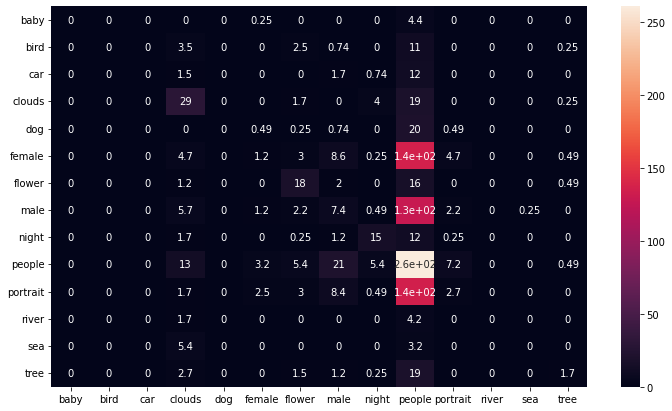

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

#--- train ---
test_loss = 0
test_correct = 0
test_total = 0

test_acc_all = 0

preds = []
targets = []

with torch.no_grad():
    for batch_num, (data, target) in enumerate(dev_loader):
        data, target = data.to(device), target.to(device)
        
        pred = model(data)
        loss = loss_function(pred, target)
        
        test_loss += loss.item()
        test_total += len(target)
        test_correct += torch.sum((pred > 0.5).float() == target) / torch.sum(target)
        preds.extend(pred.argmax(1).cpu().numpy())
        targets.extend(target.cpu().numpy())
        
        test_acc_all += (test_correct / total)

        print('Evaluating: Batch %d/%d: Loss: %.4f | Test Acc: %.3f%% (%d/%d)' % 
              (batch_num, len(dev_loader), test_loss / (batch_num + 1), 
               100. * test_correct / test_total, test_correct, test_total))

    cf_matrix = confusion_matrix(targets, preds)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 1000, 
                         index = [i for i in annotation_dict_train.keys()],
                         columns=[i for i in annotation_dict_train.keys()])
    plt.figure(figsize=(12, 7))
    sn.heatmap(df_cm, annot=True)

    
print('AVG test acc:' + str(test_acc_all*100/len(test_loader)) + '%')